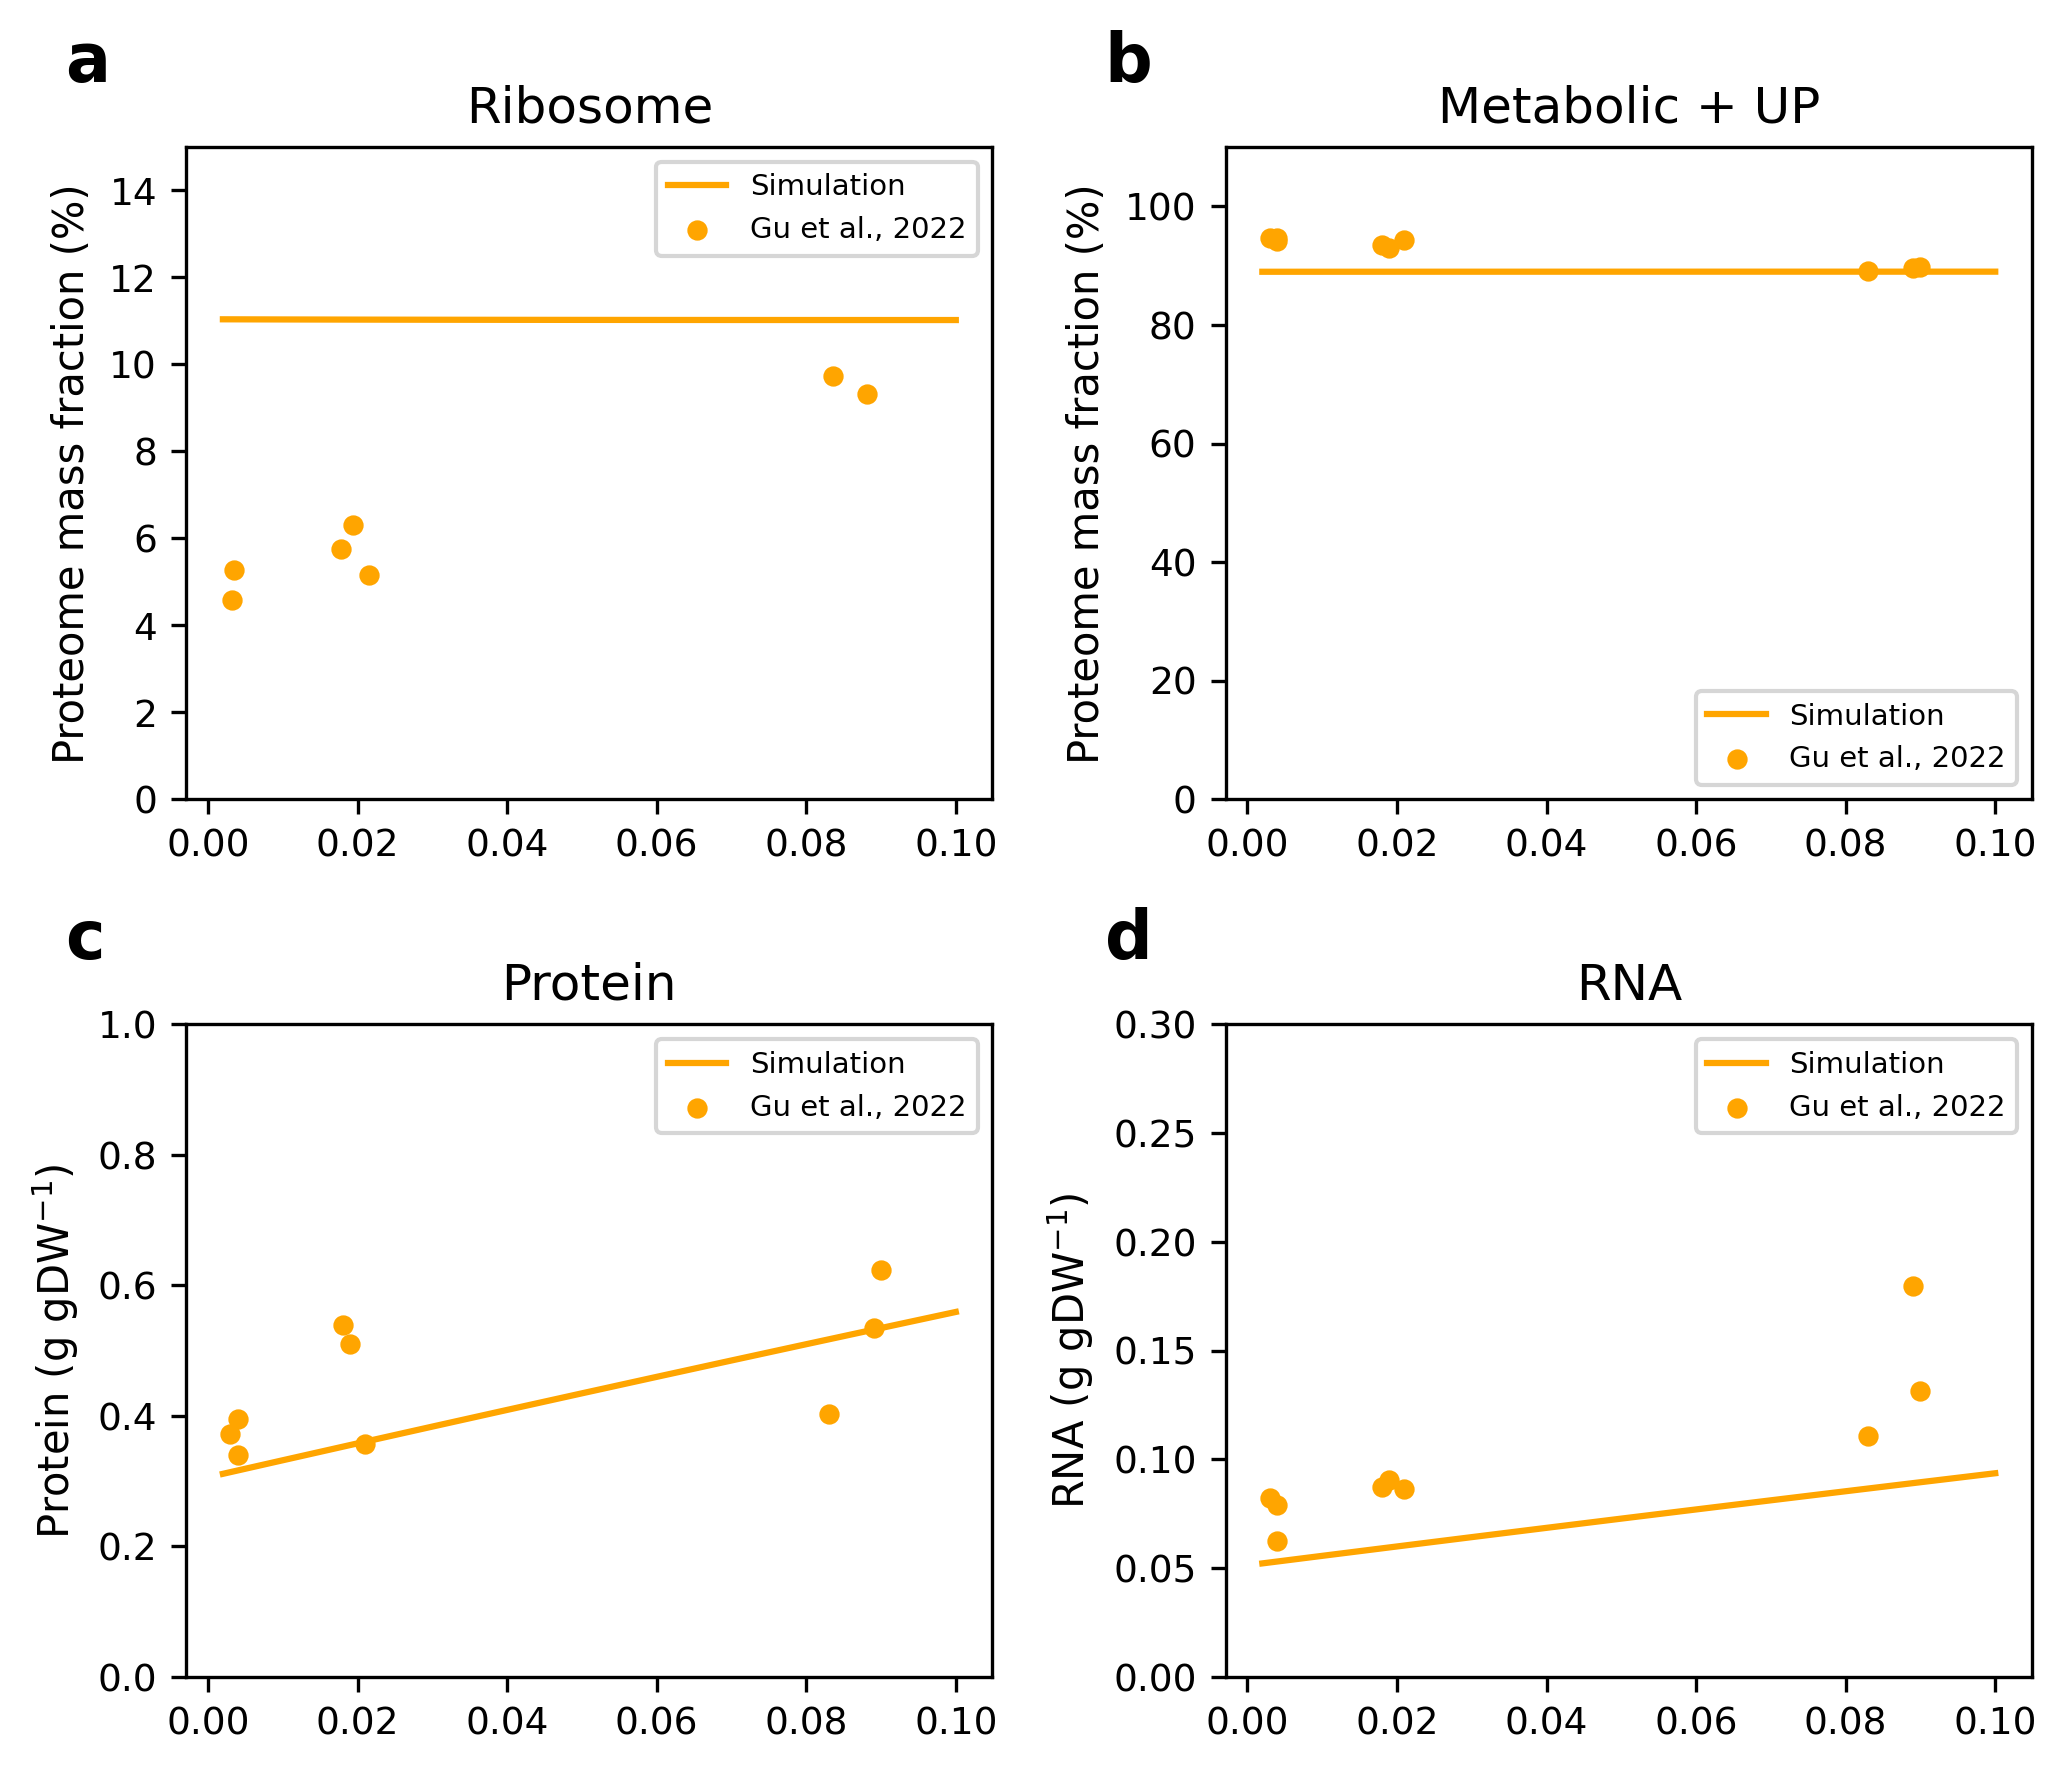

In [1]:
from simulation import Simulation
from extract_fluxes import Fluxes
import cobra
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def limitation_simulation():
    total_protein_mass=0.6
    up_phosphate_ratio=0.44*total_protein_mass
    methan_id,formate_id = "R944","R895"
    closed_reactions = ["R946", "R913", "R1165", "R983"]
    sim = Simulation()
    sim.set_parameter(model_file='pcMMP.xml', objective="R871", GAM=70, NGAM=1, excel_file='pcMMP.xlsx')
    sim.set_constraint = [f"UP >={up_phosphate_ratio}"]
    sim.close_reactions(closed_reactions)
    results = {
        "mu_list": [], "RNA_list": [],
         "metabolic_up_list": [],
        "ribosome_list": [], "total_proteins": []
    }
    mus=[0.002, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,0.1]
    for i, mu in enumerate(mus, start=1):

        sim.file_path = f"output/lp_file_phosphate_con_kcat{i}.lp"
        sim.output_file = f"output/output_phosphate_con_kcat{i}.lp"
        if sim.check_mu_optimal(mu):
            fluxes = Fluxes(sim.model, f'output/output_phosphate_con_kcat{i}.lp')
            results["mu_list"].append(mu)
            
            results["RNA_list"].append(fluxes.extract_reaction_flux("RNA"))
            total_protein = fluxes.extract_reaction_flux("total_protein")
            up = fluxes.extract_reaction_flux("UP")
            results["metabolic_up_list"].append(((up + fluxes.extract_reaction_flux("metaboicMass")) / total_protein)*100)
            results["ribosome_list"].append((fluxes.extract_reaction_flux("ribosome_mass") / total_protein)*100)
            results["total_proteins"].append(total_protein)
          
        else:
            print(f"mu={mu} is not optimal")

    return results

def plot(results_phosphate):
    
    plt.rcParams.update({
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize":9,
        "ytick.labelsize": 9,
        "legend.fontsize": 7
    })

    
    mu_list = results_phosphate['mu_list']
    
    diluation_rate_phosphate = [0.004,0.003,0.004,0.019,0.018,0.021,0.089,0.083,0.090],
    exp_phoshate_protein = [0.340122082,0.373015028,0.394486759,0.510297316,0.539535463,0.357482229,0.534967025,0.403166849,0.623595176]
    exp_phosphate_RNA = [0.062555704,0.08202801,0.078822118,0.090647634,0.087375565,0.086344534,0.17950974,0.110794618,0.131342481]
    exp_phosphate_ribsome_x = [0.003272973, 0.003487615, 0.021544347, 0.017806336, 0.019380114, 0.083529305, 0.088069874],
    exp_phosphate_ribsome_y= [4.577735363, 5.268714659, 5.153551077, 5.758158235, 6.305182504, 9.73128644, 9.328215001]
    exp_phosphate_metabolic_up_x= [0.004,0.003,0.004,0.019,0.018,0.021,0.089,0.083,0.090],    
    exp_phosphate_metabolic_up_y=[94.72140762,94.69831643,94.10985305,92.98337479,93.54020768,94.2591956,89.57755165,89.03666427,89.80582524]
        
    fig, axes = plt.subplots(2, 2, figsize=(7, 6), dpi=300)
    subplot_labels = ["a", "b", "c", "d"]
    axes[0, 0].plot(mu_list, results_phosphate['ribosome_list'], label="Simulation", color='orange')
    axes[0, 0].scatter(exp_phosphate_ribsome_x, exp_phosphate_ribsome_y, label="Gu et al., 2022", color='orange', s=15)
    axes[0, 0].set_title("Ribosome")
    axes[0, 0].set_ylabel("Proteome mass fraction (%)")
    axes[0, 0].set_ylim(0, 15)
    axes[0, 0].legend()
    axes[0, 0].text(-0.15, 1.1, subplot_labels[0], transform=axes[0, 0].transAxes,fontsize=16, fontweight='bold')

    axes[0, 1].plot(mu_list, results_phosphate['metabolic_up_list'], label="Simulation", color='orange')
    axes[0, 1].scatter(exp_phosphate_metabolic_up_x, exp_phosphate_metabolic_up_y, label="Gu et al., 2022", color='orange', s=15)
    axes[0, 1].set_title("Metabolic + UP")
    axes[0, 1].set_ylabel("Proteome mass fraction (%)")
    axes[0, 1].set_ylim(0, 110)
    axes[0, 1].legend(loc="lower right")
    axes[0, 1].text(-0.15, 1.1, subplot_labels[1], transform=axes[0, 1].transAxes,fontsize=16, fontweight='bold')

    axes[1, 0].plot(mu_list, results_phosphate['total_proteins'], label="Simulation", color='orange')
    axes[1, 0].scatter(diluation_rate_phosphate, exp_phoshate_protein, label="Gu et al., 2022", color='orange', s=15)
    axes[1, 0].set_title("Protein")
    axes[1, 0].set_ylabel("Protein (g gDW$^{-1}$)")
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].legend()
    axes[1, 0].text(-0.15, 1.1, subplot_labels[2], transform=axes[1, 0].transAxes,fontsize=16, fontweight='bold')

    axes[1, 1].plot(mu_list, results_phosphate['RNA_list'], label="Simulation", color='orange')
    axes[1, 1].scatter(diluation_rate_phosphate, exp_phosphate_RNA, label="Gu et al., 2022", color='orange', s=15)
    axes[1, 1].set_title("RNA")
    axes[1, 1].set_ylabel("RNA (g gDW$^{-1}$)")
    axes[1, 1].set_ylim(0, 0.3)
    axes[1, 1].legend()
    axes[1, 1].text(-0.15, 1.1, subplot_labels[3], transform=axes[1, 1].transAxes,fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.savefig("Figures/phosphate_constant_kcat_ribo.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    results_phosphate = limitation_simulation()
  
    plot(results_phosphate)